# Workflows

Although it would be possible to write analysis scripts using just Nipype [Interfaces](basic_interfaces.ipynb), and this may provide some advantages over directly making command-line calls, the main benefits of Nipype are the workflows.

A workflow controls the setup and the execution of individual interfaces. Let's assume you want to run multiple interfaces in a specific order, where some have to wait for others to finish while others can be executed in parallel. The nice thing about a nipype workflow is, that the workflow  will take care of input and output of each interface and arrange the execution of each interface in the most efficient way.

A workflow therefore consists of multiple [Nodes](basic_nodes.ipynb), each representing a specific [Interface](basic_interfaces.ipynb) and directed connection between those nodes. Those connections specify which output of which node should be used as an input for another node. To better understand why this is so great, let's look at an example.

## Interfaces vs. Workflows

Interfaces are the building blocks that solve well-defined tasks. We solve more complex tasks by combining interfaces with workflows:

<table style="width: 100%; font-size: 14px;">
  <thead>
    <th style="text-align:left">Interfaces</th>
    <th style="text-align:left">Workflows</th>
  </thead>
  <tbody>
    <tr>
      <td style="text-align:left">Wrap *unitary* tasks</td>
      <td style="text-align:left">Wrap *meta*-tasks
        <li style="text-align:left">implemented with nipype interfaces wrapped inside ``Node`` objects</li>
        <li style="text-align:left">subworkflows can also be added to a workflow without any wrapping</li>
      </td>
    </tr>
    <tr>
      <td style="text-align:left">Keep track of the inputs and outputs, and check their expected types</td>
      <td style="text-align:left">Do not have inputs/outputs, but expose them from the interfaces wrapped inside</td>
    </tr>
    <tr>
      <td style="text-align:left">Do not cache results (unless you use [interface caching](advanced_interfaces_caching.ipynb))</td>
      <td style="text-align:left">Cache results</td>
    </tr>
    <tr>
      <td style="text-align:left">Run by a nipype plugin</td>
      <td style="text-align:left">Run by a nipype plugin</td>
    </tr>
  </tbody>
</table>

## Preparation

Before we can start, let's first load some helper functions:

In [1]:
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt

# Let's create a short helper function to plot 3D NIfTI images
def plot_slice(fname):

    # Load the image
    img = nb.load(fname)
    data = img.get_data()

    # Cut in the middle of the brain
    cut = int(data.shape[-1]/2) + 10

    # Plot the data
    plt.imshow(np.rot90(data[..., cut]), cmap="gray")
    plt.gca().set_axis_off()

# Example 1 - ``Command-line`` execution

Let's take a look at a small preprocessing analysis where we would like to perform the following steps of processing:

    - Skullstrip an image to obtain a mask
    - Smooth the original image
    - Mask the smoothed image

This could all very well be done with the following shell script:

In [2]:
%%bash
ANAT_NAME=sub-01_T1w
ANAT=/data/dataset/sub-01/anat/${ANAT_NAME}
bet ${ANAT} /output/${ANAT_NAME}_brain -m -f 0.3
fslmaths ${ANAT} -s 2 /output/${ANAT_NAME}_smooth
fslmaths /output/${ANAT_NAME}_smooth -mas /output/${ANAT_NAME}_brain_mask /output/${ANAT_NAME}_smooth_mask

This is simple and straightforward. We can see that this does exactly what we wanted by plotting the four steps of processing.

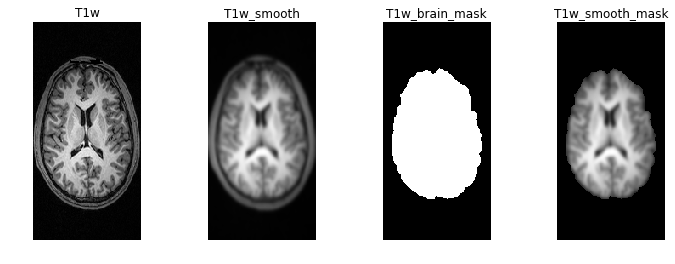

In [3]:
f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["T1w", "T1w_smooth",
                         "T1w_brain_mask", "T1w_smooth_mask"]):
    f.add_subplot(1, 4, i + 1)
    if i == 0:
        plot_slice("/data/dataset/sub-01/anat/sub-01_%s.nii.gz" % img)
    else:
        plot_slice("/output/sub-01_%s.nii.gz" % img)
    plt.title(img)

# Example 2 - ``Interface`` execution

Now let's see what this would look like if we used Nipype, but only the Interfaces functionality. It's simple enough to write a basic procedural script, this time in Python, to do the same thing as above:

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


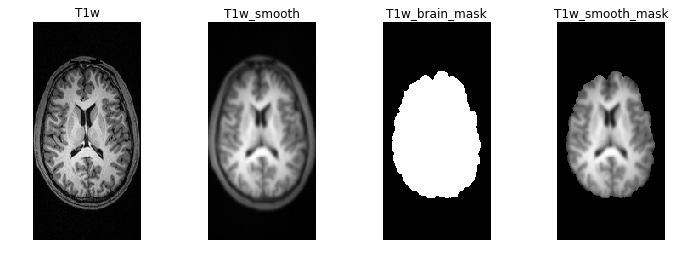

In [4]:
from nipype.interfaces import fsl

# Skullstrip process
skullstrip = fsl.BET(
    in_file="/data/dataset/sub-01/anat/sub-01_T1w.nii.gz",
    out_file="/output/sub-01_T1w_brain.nii.gz",
    mask=True)
skullstrip.run()

# Smoothing process
smooth = fsl.IsotropicSmooth(
    in_file="/data/dataset/sub-01/anat/sub-01_T1w.nii.gz",
    out_file="/output/sub-01_T1w_smooth.nii.gz",
    fwhm=4)
smooth.run()

# Masking process
mask = fsl.ApplyMask(
    in_file="/output/sub-01_T1w_smooth.nii.gz",
    out_file="/output/sub-01_T1w_smooth_mask.nii.gz",
    mask_file="/output/sub-01_T1w_brain_mask.nii.gz")
mask.run()

f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["T1w", "T1w_smooth",
                         "T1w_brain_mask", "T1w_smooth_mask"]):
    f.add_subplot(1, 4, i + 1)
    if i == 0:
        plot_slice("/data/dataset/sub-01/anat/sub-01_%s.nii.gz" % img)
    else:
        plot_slice("/output/sub-01_%s.nii.gz" % img)
    plt.title(img)

This is more verbose, although it does have its advantages. There's the automated input validation we saw previously, some of the options are named more meaningfully, and you don't need to remember, for example, that fslmaths' smoothing kernel is set in sigma instead of FWHM -- Nipype does that conversion behind the scenes.

### Can't we optimize that a bit?

As we can see above, the inputs for the **``mask``** routine ``in_file`` and ``mask_file`` are actually the output of **``skullstrip``** and **``smooth``**. We therefore somehow want to connect them. This can be accomplisehd by saving the executed routines under a given object and than using the output of those objects as input for other routines.

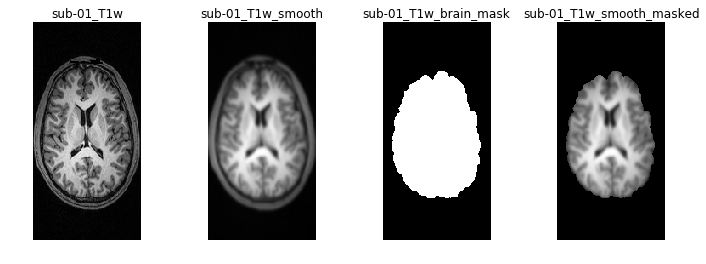

In [5]:
from nipype.interfaces import fsl

# Skullstrip process
skullstrip = fsl.BET(
    in_file="/data/dataset/sub-01/anat/sub-01_T1w.nii.gz", mask=True)
bet_result = skullstrip.run()  # skullstrip object

# Smooth process
smooth = fsl.IsotropicSmooth(
    in_file="/data/dataset/sub-01/anat/sub-01_T1w.nii.gz", fwhm=4)
smooth_result = smooth.run()  # smooth object

# Mask process
mask = fsl.ApplyMask(in_file=smooth_result.outputs.out_file,
                     mask_file=bet_result.outputs.mask_file)
mask_result = mask.run()

f = plt.figure(figsize=(12, 4))
for i, img in enumerate([skullstrip.inputs.in_file, smooth_result.outputs.out_file,
                         bet_result.outputs.mask_file, mask_result.outputs.out_file]):
    f.add_subplot(1, 4, i + 1)
    plot_slice(img)
    plt.title(img.split('/')[-1].split('.')[0].split('test_')[-1])

Here we didn't need to name the intermediate files; Nipype did that behind the scenes, and then we passed the result object (which knows those names) onto the next step in the processing stream. This is somewhat more concise than the example above, but it's still a procedural script. And the dependency relationship between the stages of processing is not particularly obvious. To address these issues, and to provide solutions to problems we might not know we have yet, Nipype offers **Workflows.**

# Example 3 - ``Workflow`` execution

What we've implicitly done above is to encode our processing stream as a directed acyclic graphs: each stage of processing is a node in this graph, and some nodes are unidirectionally dependent on others. In this case there is one input file and several output files, but there are no cycles -- there's a clear line of directionality to the processing. What the Node and Workflow classes do is make these relationships more explicit.

The basic architecture is that the Node provides a light wrapper around an Interface. It exposes the inputs and outputs of the Interface as its own, but it adds some additional functionality that allows you to connect Nodes into a Workflow.

Let's rewrite the above script with these tools:

In [6]:
# Import Node and Workflow object and FSL interface
from nipype import Node, Workflow
from nipype.interfaces import fsl

# For reasons that will later become clear, it's important to
# pass filenames to Nodes as absolute paths
from os.path import abspath
in_file = abspath("/data/dataset/sub-01/anat/sub-01_T1w.nii.gz")

# Skullstrip process
skullstrip = Node(fsl.BET(in_file=in_file, mask=True), name="skullstrip")

# Smooth process
smooth = Node(fsl.IsotropicSmooth(in_file=in_file, fwhm=4), name="smooth")

# Mask process
mask = Node(fsl.ApplyMask(), name="mask")

This looks mostly similar to what we did above, but we've left out the two crucial inputs to the ApplyMask step. We'll set those up by defining a Workflow object and then making *connections* among the Nodes.

In [7]:
# Initiation of a workflow
wf = Workflow(name="smoothflow", base_dir="/output/working_dir")

The Workflow object has a method called ``connect`` that is going to do most of the work here. This routine also checks if inputs and outputs are actually provided by the nodes that are being connected.

There are two different ways to call ``connect``:

    connect(source, "source_output", dest, "dest_input")

    connect([(source, dest, [("source_output1", "dest_input1"),
                             ("source_output2", "dest_input2")
                             ])
             ])

With the first approach you can establish one connection at a time. With the second you can establish multiple connects between two nodes at once. In either case, you're providing it with four pieces of information to define the connection:

- The source node object
- The name of the output field from the source node
- The destination node object
- The name of the input field from the destination node

We'll illustrate each method in the following cell:

In [8]:
# First the "simple", but more restricted method
wf.connect(skullstrip, "mask_file", mask, "mask_file")

# Now the more complicated method
wf.connect([(smooth, mask, [("out_file", "in_file")])])

Now the workflow is complete!

Above, we mentioned that the workflow can be thought of as a directed acyclic graph. In fact, that's literally how it's represented behind the scenes, and we can use that to explore the workflow visually:

180817-11:37:55,222 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/smoothflow/workflow_graph.png (graph2use=hierarchical, simple_form=True).


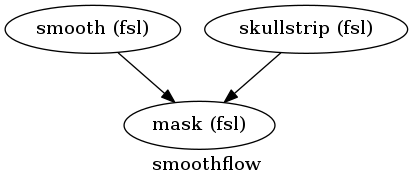

In [9]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="/output/working_dir/smoothflow/workflow_graph.png")

This representation makes the dependency structure of the workflow obvious. (By the way, the names of the nodes in this graph are the names we gave our Node objects above, so pick something meaningful for those!)

Certain graph types also allow you to further inspect the individual connections between the nodes. For example:

180817-11:37:55,414 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/smoothflow/graph.png (graph2use=flat, simple_form=True).


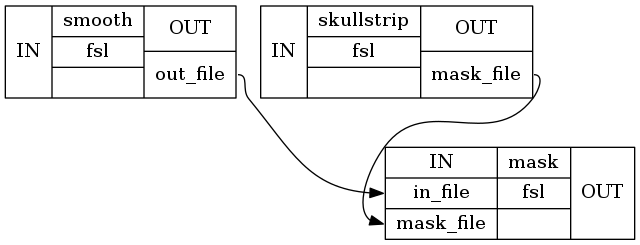

In [10]:
wf.write_graph(graph2use='flat')
from IPython.display import Image
Image(filename="/output/working_dir/smoothflow/graph_detailed.png")

Here you see very clearly, that the output ``mask_file`` of the ``skullstrip`` node is used as the input ``mask_file`` of the ``mask`` node. For more information on graph visualization, see the [Graph Visualization](./basic_graph_visualization.ipynb) section.

But let's come back to our example. At this point, all we've done is define the workflow. We haven't executed any code yet. Much like Interface objects, the Workflow object has a ``run`` method that we can call so that it executes. Let's do that and then examine the results.

In [11]:
# Specify the base directory for the working directory
wf.base_dir = "/output/working_dir"

# Execute the workflow
wf.run()

180817-11:37:55,441 nipype.workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging', 'monitoring']
180817-11:37:55,446 nipype.workflow INFO:
	 Running serially.
180817-11:37:55,447 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.smooth" in "/output/working_dir/smoothflow/smooth".
180817-11:37:55,452 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.fsl.maths.IsotropicSmooth"), a CommandLine Interface with command:
fslmaths /data/dataset/sub-01/anat/sub-01_T1w.nii.gz -s 1.69864 /output/working_dir/smoothflow/smooth/sub-01_T1w_smooth.nii.gz
180817-11:37:58,292 nipype.workflow INFO:
	 [Node] Finished "smoothflow.smooth".
180817-11:37:58,294 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.skullstrip" in "/output/working_dir/smoothflow/skullstrip".
180817-11:37:58,300 nipype.workflow INFO:
	 [Node] Running "skullstrip" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /data/dataset/sub-01/anat/sub-01_T1w.

**The specification of ``base_dir`` is very important (and is why we needed to use absolute paths above), because otherwise all the outputs would be saved somewhere in the temporary files.** Unlike interfaces, which by default spit out results to the local directry, the Workflow engine executes things off in its own directory hierarchy.

Let's take a look at the resulting images to convince ourselves we've done the same thing as before:

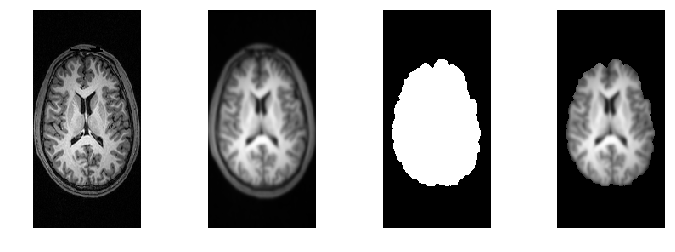

In [12]:
f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["/data/dataset/sub-01/anat/sub-01_T1w.nii.gz",
                         "/output/working_dir/smoothflow/smooth/sub-01_T1w_smooth.nii.gz",
                         "/output/working_dir/smoothflow/skullstrip/sub-01_T1w_brain_mask.nii.gz",
                         "/output/working_dir/smoothflow/mask/sub-01_T1w_smooth_masked.nii.gz"]):
    f.add_subplot(1, 4, i + 1)
    plot_slice(img)

Perfet!

Let's also have a closer look at the working directory:

In [13]:
!tree /output/working_dir/smoothflow/ -I '*js|*json|*html|*pklz|_report'

/output/working_dir/smoothflow/
├── graph_detailed.dot
├── graph_detailed.png
├── graph.dot
├── graph.png
├── mask
│   ├── command.txt
│   └── sub-01_T1w_smooth_masked.nii.gz
├── skullstrip
│   ├── command.txt
│   └── sub-01_T1w_brain_mask.nii.gz
├── smooth
│   ├── command.txt
│   └── sub-01_T1w_smooth.nii.gz
├── workflow_graph.dot
└── workflow_graph.png

3 directories, 12 files


As you can see, the name of the working directory is the name we gave the workflow ``base_dir``. And the name of the folder within is the name of the workflow object ``smoothflow``. Each node of the workflow has its' own subfolder in the ``smoothflow`` folder. And each of those subfolders contains the output of the node as well as some additional files.

# The #1 gotcha of nipype Workflows

Nipype workflows are just DAGs (Directed Acyclic Graphs) that the runner ``Plugin`` takes in and uses to compose an ordered list of nodes for execution. As a matter of fact, running a workflow will return a graph object. That's why you often see something like `<networkx.classes.digraph.DiGraph at 0x7f83542f1550>` at the end of exectuion stream when running a workflow.  

The principal implication is that ``Workflow``s *don't have inputs and outputs*, you can just access them through the ``Node`` decoration.

In practical terms, this has one clear consequence: from the resulting object of the workflow execution you don't generally have access to the value of the outputs of the interfaces. This is particularly true for Plugins with asynchronous execution.

# A workflow inside a workflow

When you start writing full-fledged analysis workflows, things can get quite complicated. Some aspects of neuroimaging analysis can be thought of as a coherent step at a level more abstract than the execution of a single command line binary. For instance, in the standard FEAT script in FSL, several calls are made in the process of using `susan` to perform nonlinear smoothing on an image. In Nipype, you can write **nested workflows**, where a sub-workflow can take the place of a Node in a given script.

Let's use the prepackaged `susan` workflow that ships with Nipype to replace our Gaussian filtering node and demonstrate how this works.

In [14]:
from nipype.workflows.fmri.fsl import create_susan_smooth

Calling this function will return a pre-written `Workflow` object:

In [15]:
susan = create_susan_smooth(separate_masks=False)

Let's display the graph to see what happens here.

180817-11:38:03,720 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/notebooks/susan_workflow.png (graph2use=hierarchical, simple_form=True).


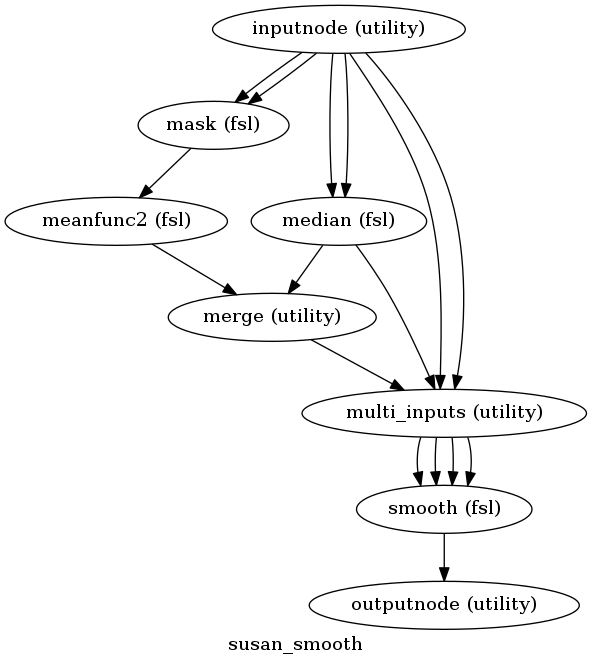

In [16]:
susan.write_graph("susan_workflow.dot")
from IPython.display import Image
Image(filename="susan_workflow.png")

We see that the workflow has an `inputnode` and an `outputnode`. While not strictly necessary, this is standard practice for workflows (especially those that are intended to be used as nested workflows in the context of a longer analysis graph) and makes it more clear how to connect inputs and outputs from this workflow.

Let's take a look at what those inputs and outputs are. Like Nodes, Workflows have `inputs` and `outputs` attributes that take a second sub-attribute corresponding to the specific node we want to make connections to.

In [17]:
print("Inputs:\n", susan.inputs.inputnode)
print("Outputs:\n", susan.outputs.outputnode)

Inputs:
 
fwhm = <undefined>
in_files = <undefined>
mask_file = <undefined>

Outputs:
 
smoothed_files = None



Note that `inputnode` and `outputnode` are just conventions, and the Workflow object exposes connections to all of its component nodes:

In [18]:
susan.inputs


inputnode = 
fwhm = <undefined>
in_files = <undefined>
mask_file = <undefined>

mask = 
args = <undefined>
environ = {'FSLOUTPUTTYPE': 'NIFTI_GZ'}
mask_file = <undefined>
op_string = -mas
out_data_type = <undefined>
out_file = <undefined>
output_type = NIFTI_GZ
suffix = _mask

meanfunc2 = 
args = <undefined>
environ = {'FSLOUTPUTTYPE': 'NIFTI_GZ'}
in_file2 = <undefined>
mask_file = <undefined>
op_string = -Tmean
out_data_type = <undefined>
out_file = <undefined>
output_type = NIFTI_GZ
suffix = _mean

median = 
args = <undefined>
environ = {'FSLOUTPUTTYPE': 'NIFTI_GZ'}
op_string = -k %s -p 50
output_type = NIFTI_GZ
split_4d = <undefined>

merge = 
axis = hstack
no_flatten = False
ravel_inputs = False

multi_inputs = 
function_str = def cartesian_product(fwhms, in_files, usans, btthresh):
    from nipype.utils.filemanip import ensure_list
    # ensure all inputs are lists
    in_files = ensure_list(in_files)
    fwhms = [fwhms] if isinstance(fwhms, (int, float)) else fwhms
    # create 

Let's see how we would write a new workflow that uses this nested smoothing step.

The susan workflow actually expects to receive and output a list of files (it's intended to be executed on each of several runs of fMRI data). We'll cover exactly how that works in later tutorials, but for the moment we need to add an additional ``Function`` node to deal with the fact that ``susan`` is outputting a list. We can use a simple `lambda` function to do this:

In [19]:
from nipype import Function
extract_func = lambda list_out: list_out[0]
list_extract = Node(Function(input_names=["list_out"],
                             output_names=["out_file"],
                             function=extract_func),
                    name="list_extract")

Now let's create a new workflow ``susanflow`` that contains the ``susan`` workflow as a sub-node. To be sure, let's also recreate the ``skullstrip`` and the ``mask`` node from the examples above.

In [20]:
# Initiate workflow with name and base directory
wf2 = Workflow(name="susanflow", base_dir="/output/working_dir")

# Create new skullstrip and mask nodes
skullstrip2 = Node(fsl.BET(in_file=in_file, mask=True), name="skullstrip")
mask2 = Node(fsl.ApplyMask(), name="mask")

# Connect the nodes to each other and to the susan workflow
wf2.connect([(skullstrip2, mask2, [("mask_file", "mask_file")]),
             (skullstrip2, susan, [("mask_file", "inputnode.mask_file")]),
             (susan, list_extract, [("outputnode.smoothed_files",
                                     "list_out")]),
             (list_extract, mask2, [("out_file", "in_file")])
             ])

# Specify the remaining input variables for the susan workflow
susan.inputs.inputnode.in_files = abspath(
    "/data/dataset/sub-01/anat/sub-01_T1w.nii.gz")
susan.inputs.inputnode.fwhm = 4

First, let's see what this new processing graph looks like.

180817-11:38:03,944 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/full_susanflow.png (graph2use=colored, simple_form=True).


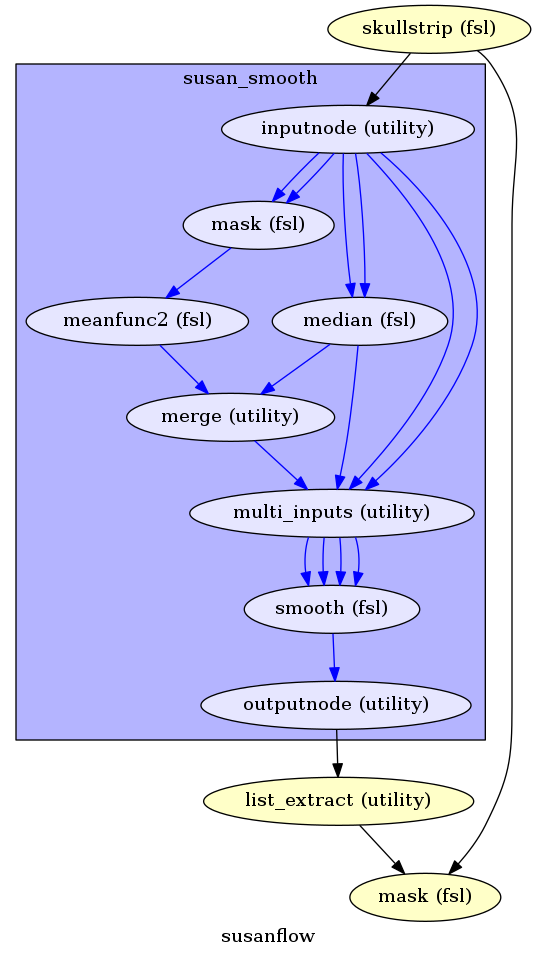

In [21]:
wf2.write_graph(dotfilename='/output/working_dir/full_susanflow.dot', graph2use='colored')
from IPython.display import Image
Image(filename="/output/working_dir/full_susanflow.png")

We can see how there is a nested smoothing workflow (blue) in the place of our previous `smooth` node. This provides a very detailed view, but what if you just wanted to give a higher-level summary of the processing steps? After all, that is the purpose of encapsulating smaller streams in a nested workflow. That, fortunately, is an option when writing out the graph:

180817-11:38:04,209 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/full_susanflow_toplevel.png (graph2use=orig, simple_form=True).


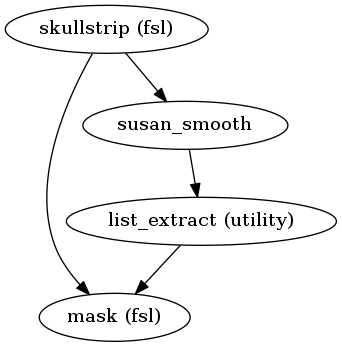

In [22]:
wf2.write_graph(dotfilename='/output/working_dir/full_susanflow_toplevel.dot', graph2use='orig')
from IPython.display import Image
Image(filename="/output/working_dir/full_susanflow_toplevel.png")

That's much more managable. Now let's execute the workflow

In [23]:
wf2.run()

180817-11:38:04,230 nipype.workflow INFO:
	 Workflow susanflow settings: ['check', 'execution', 'logging', 'monitoring']
180817-11:38:04,241 nipype.workflow INFO:
	 Running serially.
180817-11:38:04,242 nipype.workflow INFO:
	 [Node] Setting-up "susanflow.skullstrip" in "/output/working_dir/susanflow/skullstrip".
180817-11:38:04,247 nipype.workflow INFO:
	 [Node] Running "skullstrip" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /data/dataset/sub-01/anat/sub-01_T1w.nii.gz /output/working_dir/susanflow/skullstrip/sub-01_T1w_brain.nii.gz -m
180817-11:38:06,987 nipype.workflow INFO:
	 [Node] Finished "susanflow.skullstrip".
180817-11:38:06,988 nipype.workflow INFO:
	 [Node] Setting-up "susanflow.susan_smooth.mask" in "/output/working_dir/susanflow/susan_smooth/mask".
180817-11:38:06,995 nipype.workflow INFO:
	 [Node] Setting-up "_mask0" in "/output/working_dir/susanflow/susan_smooth/mask/mapflow/_mask0".
180817-11:38:06,999 nipype.workflow INFO:
	 [No

As a final step, let's look at the input and the output. It's exactly what we wanted.

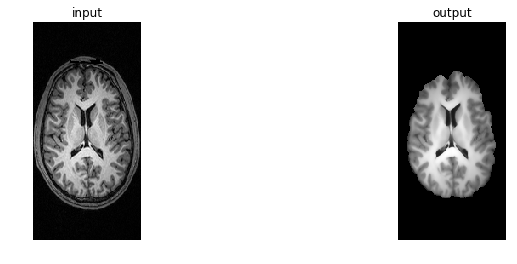

In [24]:
f = plt.figure(figsize=(12, 4))
for i, e in enumerate([["/data/dataset/sub-01/anat/sub-01_T1w.nii.gz", 'input'],
                       ["/output/working_dir/susanflow/mask/sub-01_T1w_smooth_masked.nii.gz", 
                        'output']]):
    f.add_subplot(1, 2, i + 1)
    plot_slice(e[0])
    plt.title(e[1])

# So, why are workflows so great?

So far, we've seen that you can build up rather complex analysis workflows. But at the moment, it's not been made clear why this is worth the extra trouble from writing a simple procedural script. To demonstrate the first added benefit of the Nipype, let's just rerun the ``susanflow`` workflow from above and measure the execution times.

In [25]:
%time wf2.run()

180817-11:38:27,4 nipype.workflow INFO:
	 Workflow susanflow settings: ['check', 'execution', 'logging', 'monitoring']
180817-11:38:27,15 nipype.workflow INFO:
	 Running serially.
180817-11:38:27,16 nipype.workflow INFO:
	 [Node] Setting-up "susanflow.skullstrip" in "/output/working_dir/susanflow/skullstrip".
180817-11:38:27,18 nipype.workflow INFO:
	 [Node] Cached "susanflow.skullstrip" - collecting precomputed outputs
180817-11:38:27,19 nipype.workflow INFO:
	 [Node] "susanflow.skullstrip" found cached.
180817-11:38:27,20 nipype.workflow INFO:
	 [Node] Setting-up "susanflow.susan_smooth.mask" in "/output/working_dir/susanflow/susan_smooth/mask".
180817-11:38:27,26 nipype.workflow INFO:
	 [Node] "susanflow.susan_smooth.mask" found cached.
180817-11:38:27,27 nipype.workflow INFO:
	 [Node] Setting-up "susanflow.susan_smooth.meanfunc2" in "/output/working_dir/susanflow/susan_smooth/meanfunc2".
180817-11:38:27,31 nipype.workflow INFO:
	 [Node] "susanflow.susan_smooth.meanfunc2" found cach

That happened quickly! **Workflows (actually this is handled by the Node code) are smart, and know if their inputs have changed from the last time they are run. If they have not, they don't recompute; they just turn around and pass out the resulting files from the previous run.** This is done on a node-by-node basis, also.

Let's go back to the first workflow example. What happened if we just tweak one thing:

In [26]:
wf.inputs.smooth.fwhm = 1
wf.run()

180817-11:38:27,79 nipype.workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging', 'monitoring']
180817-11:38:27,87 nipype.workflow INFO:
	 Running serially.
180817-11:38:27,88 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.smooth" in "/output/working_dir/smoothflow/smooth".
180817-11:38:27,91 nipype.workflow INFO:
	 [Node] Outdated cache found for "smoothflow.smooth".
180817-11:38:27,99 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.fsl.maths.IsotropicSmooth"), a CommandLine Interface with command:
fslmaths /data/dataset/sub-01/anat/sub-01_T1w.nii.gz -s 0.42466 /output/working_dir/smoothflow/smooth/sub-01_T1w_smooth.nii.gz
180817-11:38:28,799 nipype.workflow INFO:
	 [Node] Finished "smoothflow.smooth".
180817-11:38:28,800 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.skullstrip" in "/output/working_dir/smoothflow/skullstrip".
180817-11:38:28,804 nipype.workflow INFO:
	 [Node] Cached "smoothflow.skullstrip" - collecting precom

By changing an input value of the ``smooth`` node, this node will be re-executed. This triggers a cascade such that any file depending on the ``smooth`` node (in this case, the ``mask`` node, also recompute). However, the ``skullstrip`` node hasn't changed since the first time it ran, so it just coughed up its original files.

That's one of the main benefit of using Workflows: **efficient recomputing**. 

Another benefits of Workflows is parallel execution, which is covered under [Plugins and Distributed Computing](./basic_plugins.ipynb). With Nipype it is very easy to up a workflow to an extremely parallel cluster computing environment.

In this case, that just means that the `skullstrip` and `smooth` Nodes execute together, but when you scale up to Workflows with many subjects and many runs per subject, each can run together, such that (in the case of unlimited computing resources), you could process 50 subjects with 10 runs of functional data in essentially the time it would take to process a single run.

To emphasize the contribution of Nipype here, you can write and test your workflow on one subject computing on your local CPU, where it is easier to debug. Then, with the change of a single function parameter, you can scale your processing up to a 1000+ node SGE cluster.

### Exercise 1

Create a workflow that connects three nodes for:
- skipping the first 3 dummy scans using ``fsl.ExtractROI``
- applying motion correction using ``fsl.MCFLIRT`` (register to the mean volume, use NIFTI as output type)
- correcting for slice wise acquisition using ``fsl.SliceTimer`` (assumed that slices were acquired with interleaved order and time repetition was 2.5, use NIFTI as output type)

In [27]:
# write your solution here

In [28]:
# importing Node and Workflow
from nipype import Workflow, Node
# importing all interfaces
from nipype.interfaces.fsl import ExtractROI, MCFLIRT, SliceTimer

Defining all nodes

In [29]:
# extracting all time levels but not the first four
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# using MCFLIRT for motion correction to the mean volume
mcflirt = Node(MCFLIRT(mean_vol=True,
                    output_type='NIFTI'),
               name="mcflirt")

# correcting for slice wise acquisition (acquired with interleaved order and time repetition was 2.5)
slicetimer = Node(SliceTimer(interleaved=True,
                             output_type='NIFTI',
                             time_repetition=2.5),
                  name="slicetimer")

Creating a workflow

In [30]:
# Initiation of a workflow
wf_ex1 = Workflow(name="exercise1", base_dir="/output/working_dir")

# connect nodes with each other
wf_ex1.connect([(extract, mcflirt, [('roi_file', 'in_file')]),
                (mcflirt, slicetimer, [('out_file', 'in_file')])])

# providing a input file for the first extract node
extract.inputs.in_file = "/data/dataset/sub-01/func/sub-01_task-rest-EC_bold.nii.gz"

### Exercise 2
Visualize and run the workflow

In [31]:
# write your solution here

We learnt 2 methods of plotting graphs:  

180817-11:38:29,546 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/exercise1/workflow_graph.png (graph2use=hierarchical, simple_form=True).


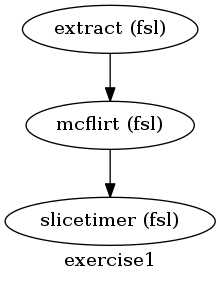

In [32]:
wf_ex1.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="/output/working_dir/exercise1/workflow_graph.png")

And more detailed graph:

180817-11:38:29,794 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/exercise1/graph.png (graph2use=flat, simple_form=True).


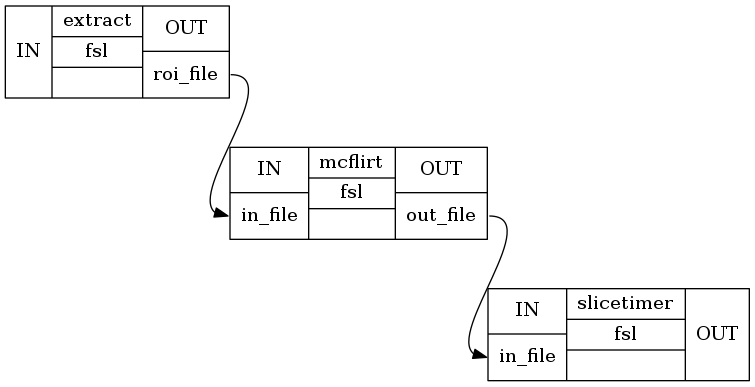

In [33]:
wf_ex1.write_graph(graph2use='flat')
from IPython.display import Image
Image(filename="/output/working_dir/exercise1/graph_detailed.png")

if everything works good, we're ready to run the workflow:

In [34]:
wf_ex1.run()

180817-11:38:29,804 nipype.workflow INFO:
	 Workflow exercise1 settings: ['check', 'execution', 'logging', 'monitoring']
180817-11:38:29,810 nipype.workflow INFO:
	 Running serially.
180817-11:38:29,811 nipype.workflow INFO:
	 [Node] Setting-up "exercise1.extract" in "/output/working_dir/exercise1/extract".
180817-11:38:29,817 nipype.workflow INFO:
	 [Node] Running "extract" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /data/dataset/sub-01/func/sub-01_task-rest-EC_bold.nii.gz /output/working_dir/exercise1/extract/sub-01_task-rest-EC_bold_roi.nii 4 -1
180817-11:38:30,213 nipype.workflow INFO:
	 [Node] Finished "exercise1.extract".
180817-11:38:30,215 nipype.workflow INFO:
	 [Node] Setting-up "exercise1.mcflirt" in "/output/working_dir/exercise1/mcflirt".
180817-11:38:30,221 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /output/working_dir/exercis

we can now check the output:

In [35]:
! ls -lh /output/working_dir/exercise1

total 412K
-rw-r--r-- 1 neuro root 319K Aug 17 11:38 d3.js
drwxr-sr-x 3 neuro root 4.0K Aug 17 11:38 extract
-rw-r--r-- 1 neuro root 1006 Aug 17 11:38 graph1.json
-rw-r--r-- 1 neuro root  435 Aug 17 11:38 graph_detailed.dot
-rw-r--r-- 1 neuro root  18K Aug 17 11:38 graph_detailed.png
-rw-r--r-- 1 neuro root  149 Aug 17 11:38 graph.dot
-rw-r--r-- 1 neuro root  380 Aug 17 11:38 graph.json
-rw-r--r-- 1 neuro root  15K Aug 17 11:38 graph.png
-rw-r--r-- 1 neuro root 6.6K Aug 17 11:38 index.html
drwxr-sr-x 3 neuro root 4.0K Aug 17 11:38 mcflirt
drwxr-sr-x 3 neuro root 4.0K Aug 17 11:38 slicetimer
-rw-r--r-- 1 neuro root  266 Aug 17 11:38 workflow_graph.dot
-rw-r--r-- 1 neuro root  14K Aug 17 11:38 workflow_graph.png
